# Audio Classification Using Mobilenet

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '20'

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from pathlib import Path
import tensorflow_hub as hub
from IPython.display import Audio, display

## Loading data

In [2]:
train_paths = Path().glob('./temp/Train/*.wav')
train_paths = [str(path.absolute()) for path in train_paths]
train_labels = [int(x.split(os.path.sep)[-1].split('_')[0]) for x in train_paths]

test_paths = Path().glob('./temp/Test/*.wav')
test_paths = [str(path.absolute()) for path in test_paths]
test_labels = [int(x.split(os.path.sep)[-1].split('_')[0]) for x in test_paths]

print(len(train_paths), 'Training data!')
print(len(test_paths), 'Test data!')

15762 Training data!
1151 Test data!


Let's visualize some data

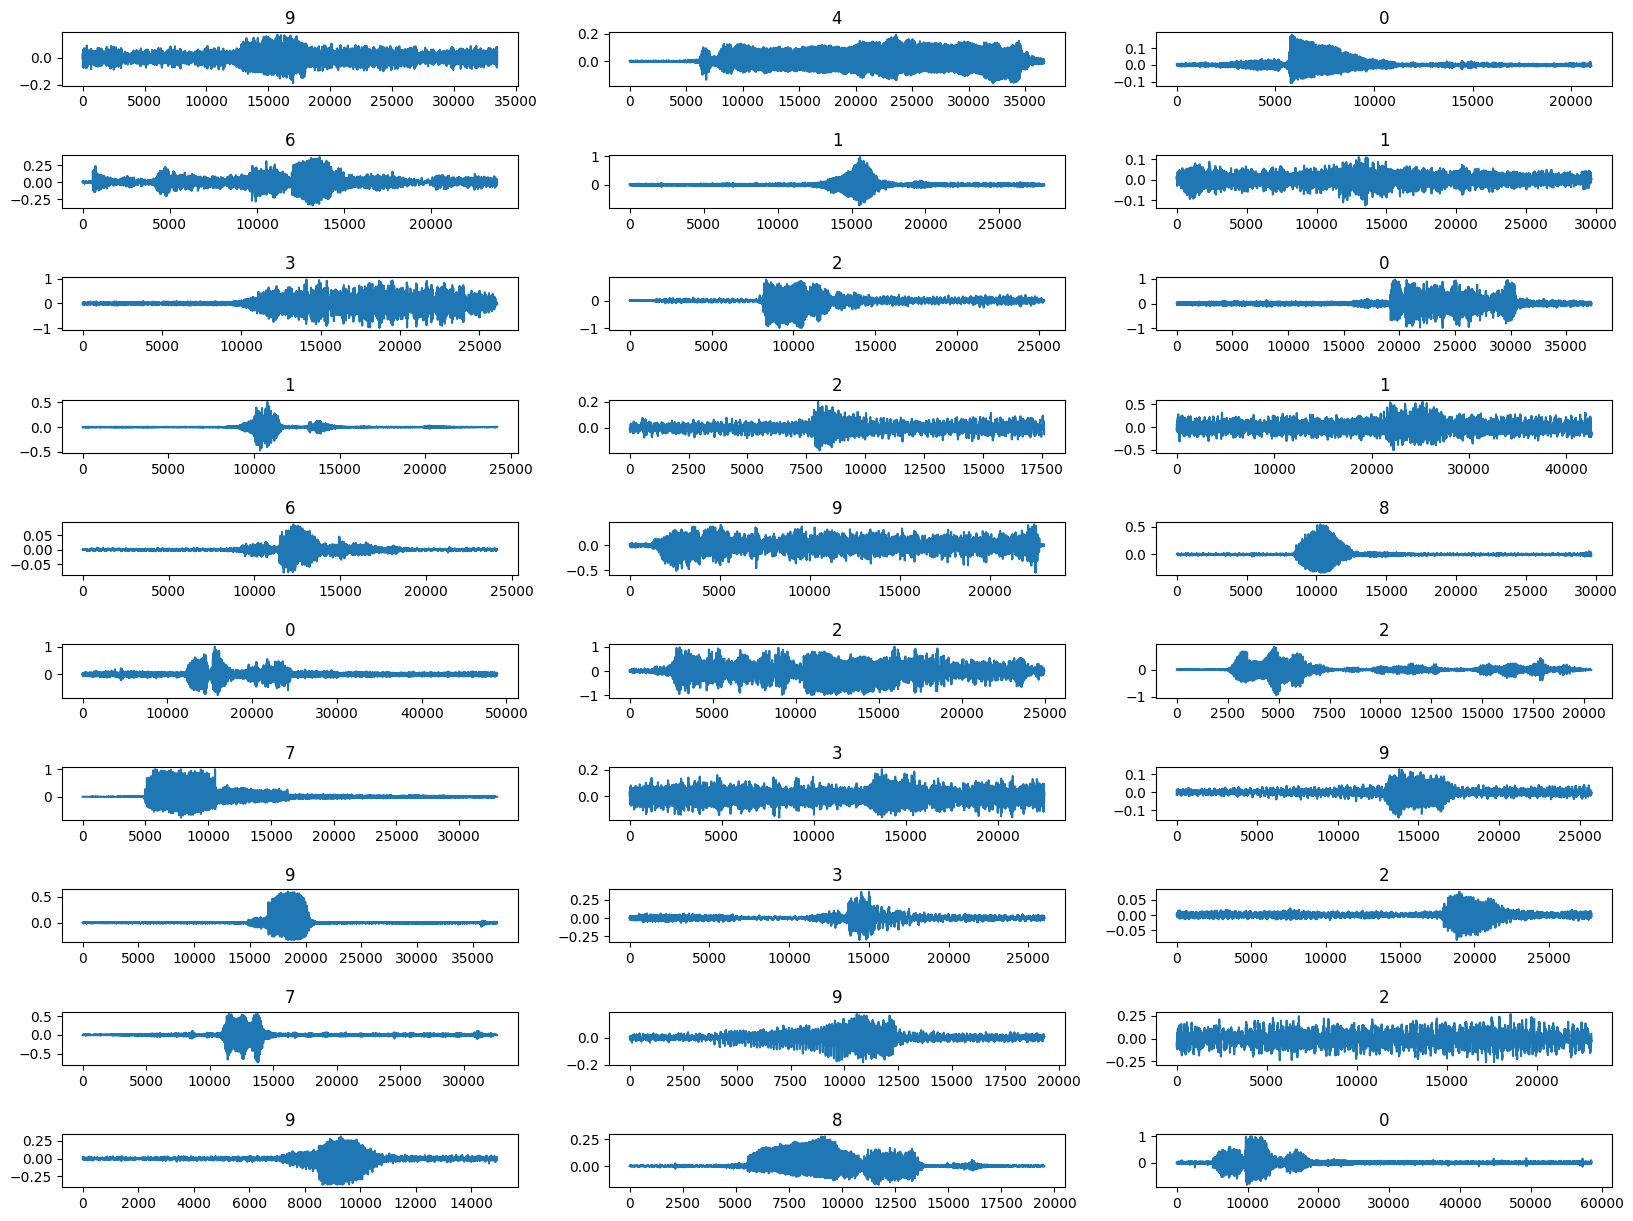

In [3]:
fig = plt.figure(figsize=(20, 15))
for i, (path, lbl) in enumerate(zip(train_paths, train_labels)):
    if i >= 30: break

    ax = plt.subplot(10, 3, i + 1)
    file = tf.io.read_file(path)
    wav, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    ax.plot(wav)
    ax.set_title(f'{lbl}')

fig.subplots_adjust(hspace=1.3)

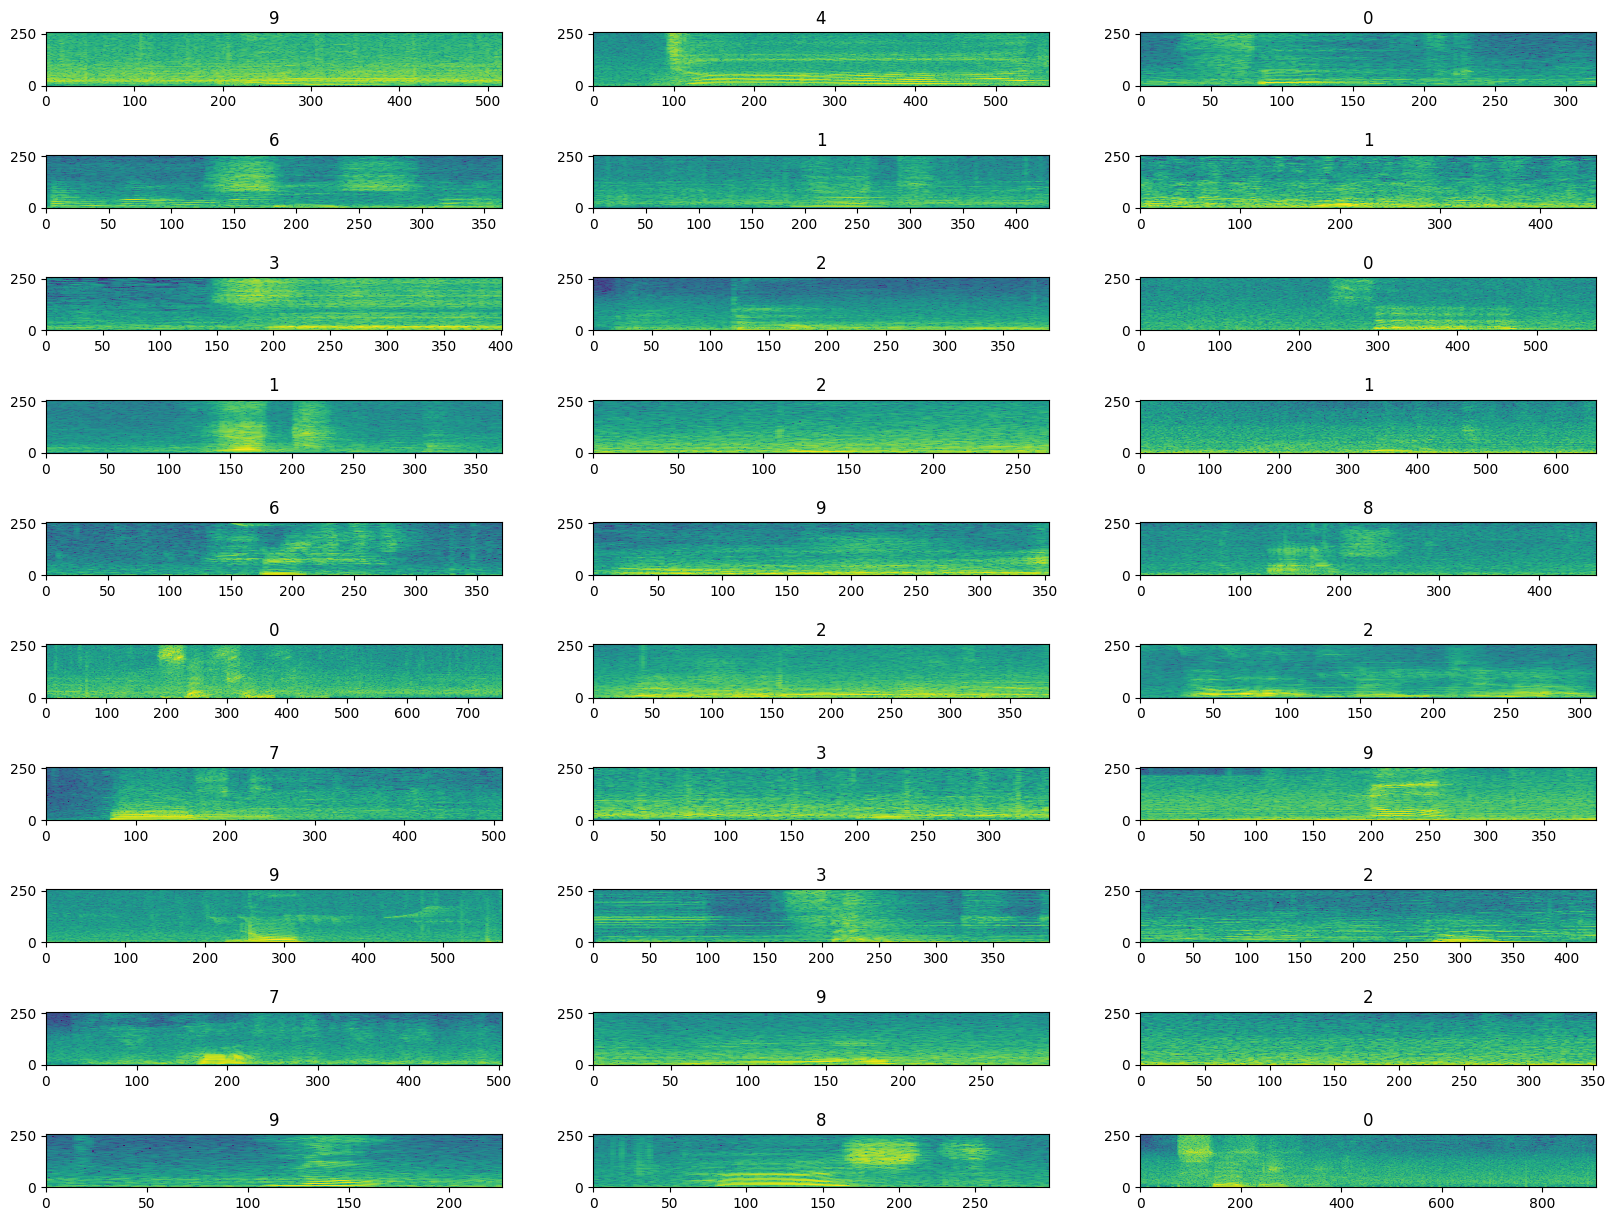

In [4]:
fig = plt.figure(figsize=(20, 15))
for i, (path, lbl) in enumerate(zip(train_paths, train_labels)):
    if i >= 30: break

    ax = plt.subplot(10, 3, i + 1)
    file = tf.io.read_file(path)
    wav, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    spectrum = tf.abs(tf.signal.stft(wav, frame_length=511, frame_step=64))

    log_spec = np.log(spectrum.numpy().T + np.finfo(np.float32).eps)
    ax.pcolormesh(log_spec)
    ax.set_title(f'{lbl}')

fig.subplots_adjust(hspace=1.3)

## Building a pipeline

In [5]:
SAMPLE_RATE = 16000
BATCH_SIZE = 32
BUFFER = 10000
AUTOTUNE = tf.data.experimental.AUTOTUNE

#AUDIO PARAMS
FRAME_LENGTH = 127
FRAME_STEP = 64
FFT_LENGTH = None
NUM_MEL_BINS = 64
LOWER_EDGE_HERTZ, UPPER_EDGE_HERTZ = 80.0, 7800.0
BUFFER = 10000

def apply_frequency_mask(mel_spectrogram, mask_param=10, num_masks=1):
    freq_masked = mel_spectrogram
    num_mel_channels = tf.shape(freq_masked)[1]

    for _ in range(num_masks):
        f = tf.random.uniform([], minval=0, maxval=mask_param, dtype=tf.int32)
        f0 = tf.random.uniform([], minval=0, maxval=num_mel_channels - f, dtype=tf.int32)

        mask = tf.concat([
            tf.ones((tf.shape(freq_masked)[0], f0), dtype=freq_masked.dtype),
            tf.zeros((tf.shape(freq_masked)[0], f), dtype=freq_masked.dtype),
            tf.ones((tf.shape(freq_masked)[0], num_mel_channels - f - f0), dtype=freq_masked.dtype)
        ], axis=1)

        freq_masked = freq_masked * mask

    return freq_masked


def apply_time_mask(mel_spectrogram, mask_param=15, num_masks=1):
    time_masked = mel_spectrogram
    num_time_steps = tf.shape(time_masked)[0]

    for _ in range(num_masks):
        t = tf.random.uniform([], minval=0, maxval=mask_param, dtype=tf.int32)
        t0 = tf.random.uniform([], minval=0, maxval=num_time_steps - t, dtype=tf.int32)

        mask = tf.concat([
            tf.ones((t0, tf.shape(time_masked)[1]), dtype=time_masked.dtype),
            tf.zeros((t, tf.shape(time_masked)[1]), dtype=time_masked.dtype),
            tf.ones((num_time_steps - t - t0, tf.shape(time_masked)[1]), dtype=time_masked.dtype)
        ], axis=0)

        time_masked = time_masked * mask

    return time_masked


def get_spectogram(audio):
    spectogram = tf.signal.stft(audio, frame_length=FRAME_LENGTH, frame_step=FRAME_STEP, fft_length=FFT_LENGTH)
    spectogram = tf.abs(spectogram)

    num_spectrogram_bins = spectogram.shape[-1]
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(NUM_MEL_BINS, 
                                                                        num_spectrogram_bins, 
                                                                        SAMPLE_RATE,
                                                                        LOWER_EDGE_HERTZ,
                                                                        UPPER_EDGE_HERTZ)

    # Apply the mel-scale filter bank to the magnitude spectrogram
    mel_spectrogram = tf.tensordot(spectogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(spectogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    return log_mel_spectrogram



def extract_spectrogram(wav_data):
    ''' run YAMNet to extract spectrogram from the wav data '''
    scores, embeddings, spectrogram = yamnet_model(wav_data)
    return spectrogram


def load_audio(path):
    file = tf.io.read_file(path)
    wav, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    return wav


def load_dataset(path, label):
    audio = load_audio(path)
    spectrogram = get_spectogram(audio)
    # spectrogram = tf.expand_dims(spectrogram, axis=-1)
    label = tf.one_hot(label, 10)
    return spectrogram, label
    
    
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(load_dataset, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache()
train_ds = train_ds.map(lambda x, y: (apply_frequency_mask(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (apply_time_mask(x), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(BUFFER)
train_ds = train_ds.padded_batch(BATCH_SIZE)
train_ds = train_ds.prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(load_dataset, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache()
test_ds = test_ds.padded_batch(BATCH_SIZE)
test_ds = test_ds.prefetch(AUTOTUNE)

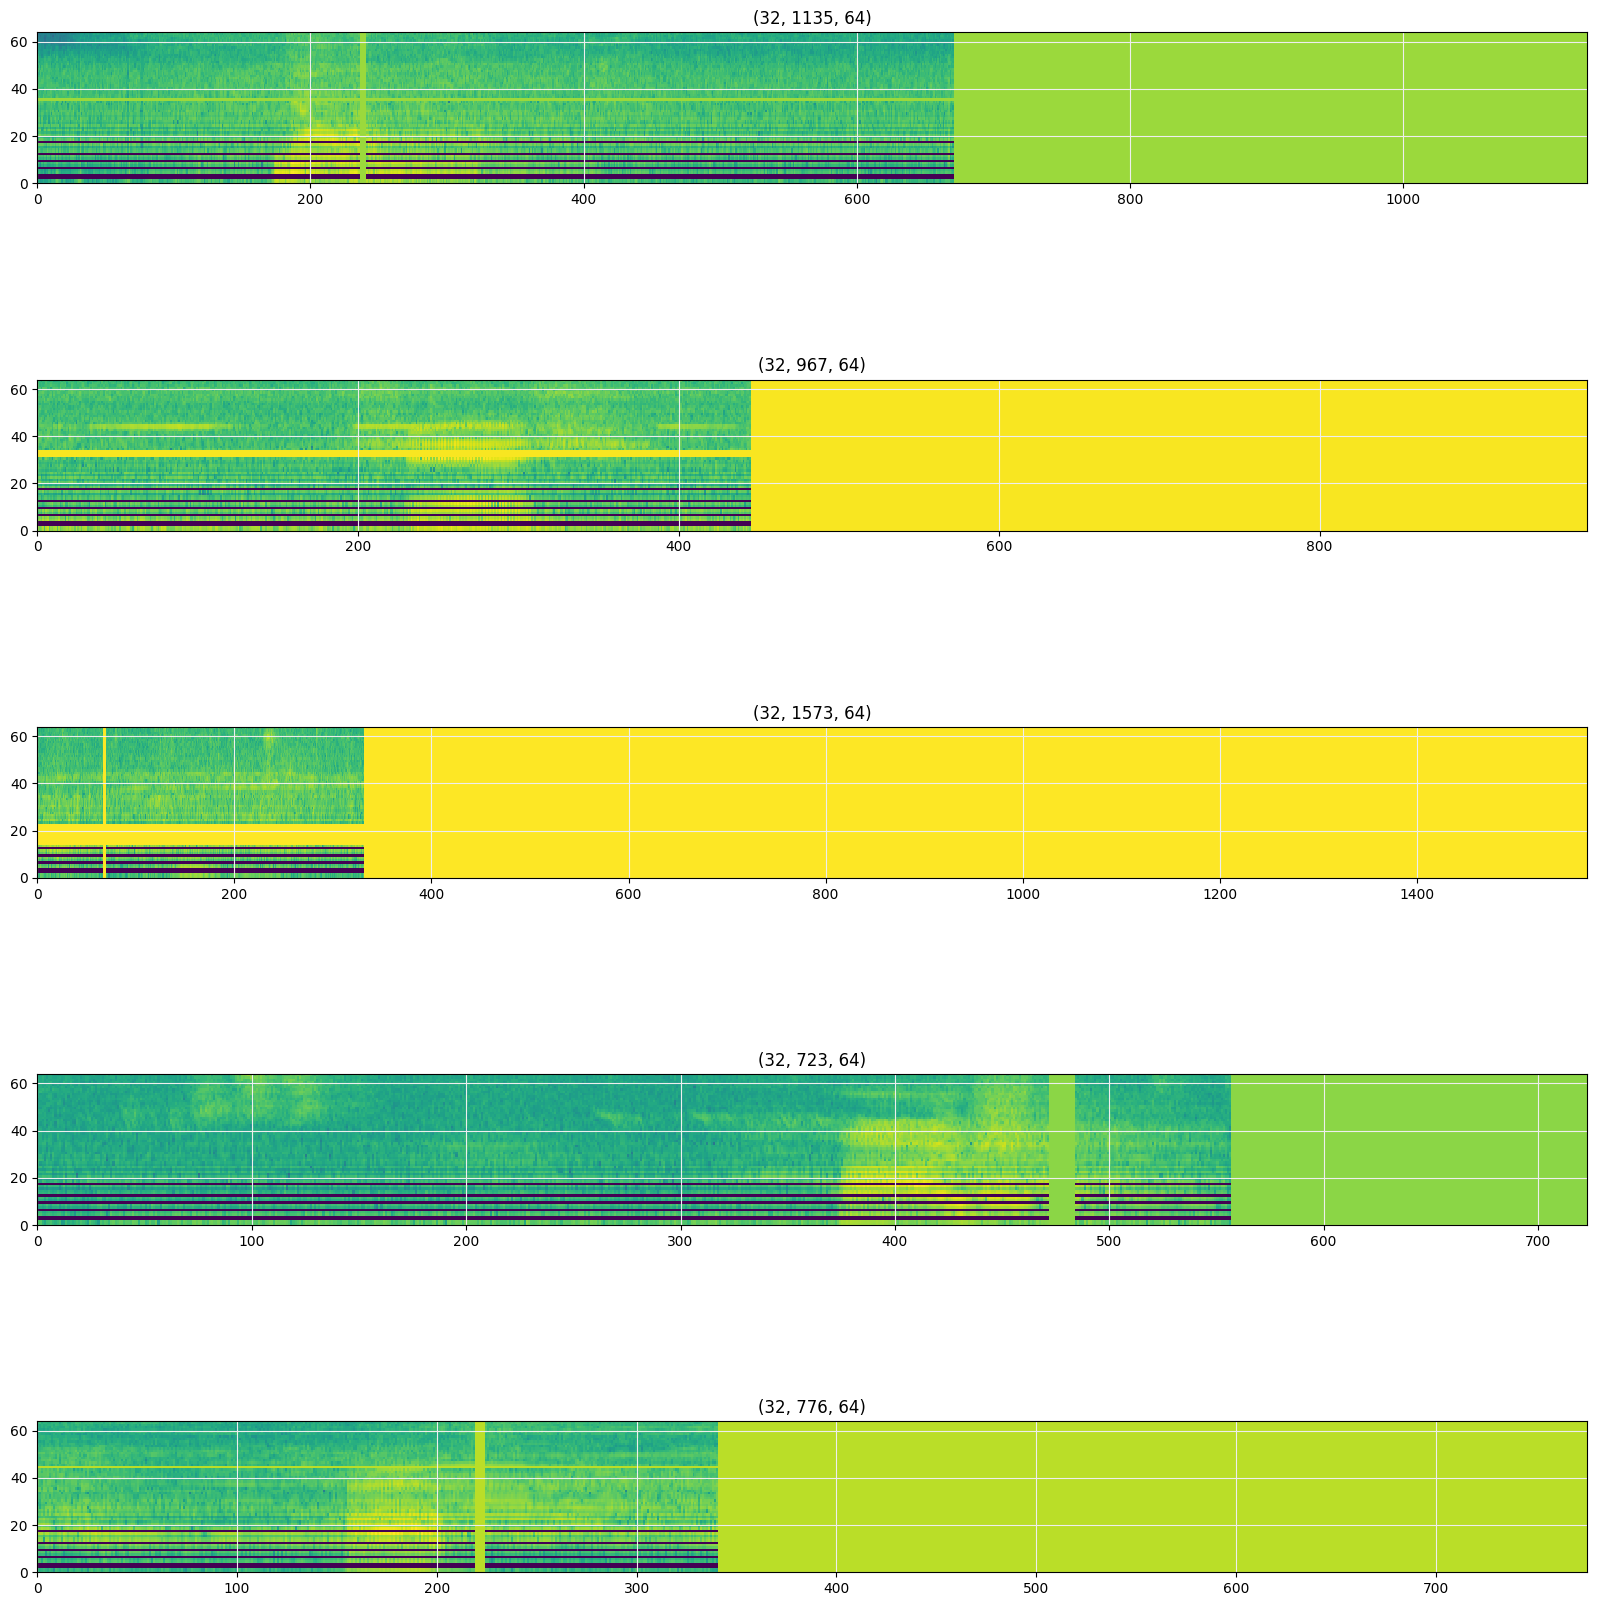

In [6]:
fig = plt.figure(figsize=(20, 20))
for i, (x, y) in enumerate(train_ds.take(5)):
    ax = plt.subplot(5, 1, i + 1)
    ax.pcolormesh(tf.transpose(x[0]))
    ax.grid(c='#eee')
    ax.set_title(x.shape)
fig.subplots_adjust(hspace=1.3)

### Build the model

In [7]:
from keras.layers import Layer, Conv1D, BatchNormalization, Dropout, Activation, Normalization, Input, MaxPool1D, Dense
from keras.layers import GlobalAveragePooling1D, DepthwiseConv1D, Add, Bidirectional, LSTM, Normalization, ReLU
from keras.models import Model
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from keras.metrics import F1Score, CategoricalAccuracy, Precision, Recall
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, ModelCheckpoint

In [8]:
class ConvBlock(Layer):
    def __init__(self, filters, kernel_size=3, momentum=0.99):
        super(ConvBlock, self).__init__()

        self.conv = Conv1D(filters=filters, 
                           kernel_size=kernel_size, 
                           padding='same', 
                           name='conv')
        
        self.bn = BatchNormalization(momentum=momentum, 
                                     name='bn')
        
        self.act = ReLU(max_value=6, 
                        name='act')

    def call(self, input_tensor, training=False):
        x = self.conv(input_tensor)
        x = self.bn(x, training=training)
        x = self.act(x)
        return x

In [9]:
class BottleNeck(Layer):
    def __init__(self, out_channel=None, kernel_size=3, stride=1, expansion_factor=6, momentum=0.99):
        super(BottleNeck, self).__init__()

        self.norm = keras.layers.Normalization()
        self.momentum = momentum
        self.expansion_factor = expansion_factor
        self.out_channel = out_channel
        self.stride = stride

        self.depthwise = DepthwiseConv1D(kernel_size=kernel_size, 
                                         strides=stride,
                                         padding='same', 
                                         use_bias=False,
                                         name='depthwise')
        
        self.bn_depthwise = BatchNormalization(momentum=momentum, name='depthwise_bn')
        self.bn_expand = BatchNormalization(momentum=momentum, name='expand_bn')
        self.bn_project = BatchNormalization(momentum=momentum, name='project_bn')
        self.bn_skip = BatchNormalization(momentum=momentum, name='skip_bn')
        
        self.act = ReLU(max_value=6,
                        name='relu_act')
        self.add = Add(name='add')


    def build(self, input_shape):
        depth = input_shape[-1]
        self.out_channel = depth if self.out_channel is None else self.out_channel

        self.expand = Conv1D(filters=self.expansion_factor * depth,
                             kernel_size=1, 
                             padding='same', 
                             use_bias=False, 
                             name='expand_conv')

        self.project = Conv1D(filters=self.out_channel, 
                              kernel_size=1, 
                              padding='same', 
                              use_bias=False,
                              name='project_conv')

        self.skip_connection = Conv1D(filters=self.out_channel, 
                                      kernel_size=1, 
                                      name='skip')
        self.built = True


    def call(self, input_tensor, training=False):
        x = self.expand(self.norm(input_tensor))
        x = self.bn_expand(x, training=training)
        x = self.act(x)

        x = self.depthwise(x)
        x = self.bn_depthwise(x, training=training)
        x = self.act(x)

        x = self.project(x)
        x = self.bn_project(x, training=training)

        if self.stride == 1:
            skip = self.skip_connection(input_tensor)
            skip = self.bn_skip(skip, training=training)
            x = self.add([x, skip])
            
        return x

In [10]:
class MobileNet(Model):
    def __init__(self, num_classes, momentum=0.99):
        super(MobileNet, self).__init__()

        self.norm_layer = Normalization()
        self.conv1 = ConvBlock(filters=32, kernel_size=3, momentum=momentum)
        
        self.bottlenecks1 = [BottleNeck(out_channel=64,
                                        stride=2 if i == 0 else 1, 
                                        expansion_factor=4, momentum=momentum) 
                             for i in range(4)]

        self.bottlenecks2 = [BottleNeck(out_channel=128,
                                        stride=2 if i == 0 else 1, 
                                        expansion_factor=4, momentum=momentum) 
                             for i in range(4)]

        self.bottlenecks3 = [BottleNeck(out_channel=256,
                                        stride=2 if i == 0 else 1, 
                                        expansion_factor=4, momentum=momentum) 
                             for i in range(4)]

        self.bottlenecks4 = [BottleNeck(out_channel=256,
                                        stride=2 if i == 0 else 1, 
                                        expansion_factor=4, momentum=momentum) 
                             for i in range(2)]

        self.global_avg = GlobalAveragePooling1D(name='global_avg')
        self.dropout = Dropout(0.5, name='dropout')
        self.classifier = Dense(num_classes)


    def build(self, input_shape):
        inputs = Input(shape=input_shape)
        self.call(inputs)
        self.built = True


    def call(self, input_tensor, training=False):
        x = self.norm_layer(input_tensor)
        x = self.conv1(x, training=training)

        for bottleneck in self.bottlenecks1:
            x = bottleneck(x, training=training)

        for bottleneck in self.bottlenecks2:
            x = bottleneck(x, training=training)

        for bottleneck in self.bottlenecks3:
            x = bottleneck(x, training=training)

        for bottleneck in self.bottlenecks4:
            x = bottleneck(x, training=training)

        x = self.global_avg(x)
        x = self.dropout(x, training=training)
        x = self.classifier(x)
        return x

In [11]:
model = MobileNet(10, momentum=0.9)
model.build(input_shape=x.shape[1:])
model.summary()

Model: "mobile_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 776, 64)           129       
 on)                                                             
                                                                 
 conv_block (ConvBlock)      (None, 776, 32)           6304      
                                                                 
 bottle_neck (BottleNeck)    (None, 388, 64)           14017     
                                                                 
 bottle_neck_1 (BottleNeck)  (None, 388, 64)           40385     
                                                                 
 bottle_neck_2 (BottleNeck)  (None, 388, 64)           40385     
                                                                 
 bottle_neck_3 (BottleNeck)  (None, 388, 64)           40385     
                                                        

In [12]:
model.compile(
    loss=CategoricalCrossentropy(from_logits=True, label_smoothing=0.05),
    optimizer=Adam(),
    metrics=['accuracy']
)

def get_scheduler(initial_learning_rate, weight=0.99, min_learning_rate=1e-5):
    def func(epoch):
        return max(min_learning_rate, initial_learning_rate * weight ** epoch)
    return func


scheduler = get_scheduler(3e-3, weight=0.90)
lr_scheduler = LearningRateScheduler(scheduler)
checkpoint = ModelCheckpoint('./checkpoints/mobilenet/best.h5', 
                             save_best_only=True, 
                             monitor='val_accuracy',
                             save_weights_only=True)
callbacks = [lr_scheduler, checkpoint]

In [13]:
print('Caching data from pipeline')
for i, (x, y) in enumerate(train_ds):
    print(f'\r{i:>5}', end='')

Caching data from pipeline
  492

In [14]:
history = model.fit(train_ds, epochs=40, validation_data=test_ds, callbacks=callbacks)

Epoch 1/40


I0000 00:00:1720225408.028519  101213 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


493/493 [==============================] - 270s 487ms/step - loss: 2.2000 - accuracy: 0.1833 - val_loss: 2.2629 - val_accuracy: 0.2302 - lr: 0.0030
Epoch 2/40
493/493 [==============================] - 92s 187ms/step - loss: 1.8985 - accuracy: 0.3212 - val_loss: 2.6704 - val_accuracy: 0.2745 - lr: 0.0027
Epoch 3/40
493/493 [==============================] - 84s 169ms/step - loss: 1.7232 - accuracy: 0.4032 - val_loss: 2.2322 - val_accuracy: 0.3449 - lr: 0.0024
Epoch 4/40
493/493 [==============================] - 86s 173ms/step - loss: 1.5491 - accuracy: 0.4783 - val_loss: 1.6681 - val_accuracy: 0.5091 - lr: 0.0022
Epoch 5/40
493/493 [==============================] - 82s 165ms/step - loss: 1.3453 - accuracy: 0.5829 - val_loss: 1.5209 - val_accuracy: 0.5873 - lr: 0.0020
Epoch 6/40
493/493 [==============================] - 81s 163ms/step - loss: 1.2170 - accuracy: 0.6413 - val_loss: 1.0972 - val_accuracy: 0.7255 - lr: 0.0018
Epoch 7/40
493/493 [==============================] - 83s 168m

## Evaluation

In [23]:
from sklearn.metrics import classification_report

def plot(history, key, ax):
    val_key = 'val_' + key
    ax.plot(history.epoch, history.history[key], label=key)
    ax.plot(history.epoch, history.history[val_key], label=val_key)
    ax.grid(c='#eee')
    ax.set_title(f'{key.capitalize()} per epoch')
    ax.set_xlabel('epoch')
    ax.set_ylabel(f'{key}')
    plt.legend();

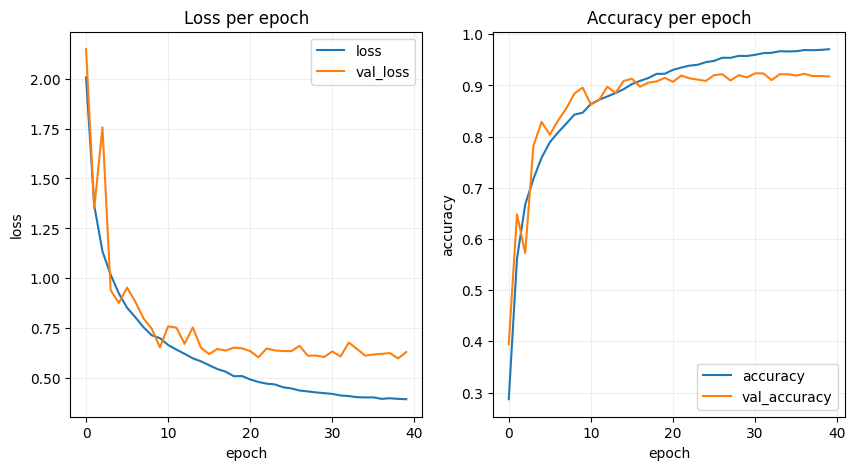

In [24]:
fig = plt.figure(figsize=(10, 5))

ax = plt.subplot(1, 2, 1)
plot(history, 'loss', ax);

ax = plt.subplot(1, 2, 2)
plot(history, 'accuracy', ax);

In [27]:
model.load_weights('./checkpoints/mobilenet/best.h5')

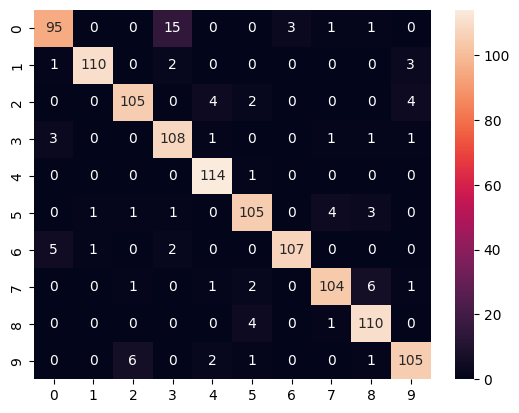

In [28]:
pred = model.predict(test_ds, verbose=0)
pred = tf.argmax(pred, axis=-1)

y_true = tf.concat([tf.argmax(l, axis=-1) for s, l in test_ds], axis=-1)
    
conf_matrix = tf.math.confusion_matrix(y_true, pred)

classes = [str(i) for i in range(10)]
sns.heatmap(conf_matrix, annot=True, xticklabels=classes, yticklabels=classes, fmt='g');

In [29]:
print(classification_report(y_true, pred, target_names=classes))

              precision    recall  f1-score   support

           0       0.91      0.83      0.87       115
           1       0.98      0.95      0.96       116
           2       0.93      0.91      0.92       115
           3       0.84      0.94      0.89       115
           4       0.93      0.99      0.96       115
           5       0.91      0.91      0.91       115
           6       0.97      0.93      0.95       115
           7       0.94      0.90      0.92       115
           8       0.90      0.96      0.93       115
           9       0.92      0.91      0.92       115

    accuracy                           0.92      1151
   macro avg       0.92      0.92      0.92      1151
weighted avg       0.92      0.92      0.92      1151



## Export Model

In [39]:
class ExportModel(tf.Module):
    def __init__(self, model, get_spectogram):
        super(ExportModel, self).__init__()
        self.model = model
        self.get_spectogram = get_spectogram

    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.float32, shape=[None,])])
    def __call__(self, wav):
        x = self.get_spectogram(wav)
        x = self.model(x[tf.newaxis, ...], training=False)
        return x

In [40]:
exportModel = ExportModel(model, get_spectogram)
for i in range(20):
    path = test_paths[i]
    file = tf.io.read_file(path)
    wav, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    y_pred = exportModel(wav)
    y_pred = tf.argmax(y_pred, axis=-1)
    print(f'Predicted {y_pred} and the actual label is {test_labels[i]}')
    display(Audio(filename=test_paths[i]))

Predicted [9] and the actual label is 9


Predicted [1] and the actual label is 1


Predicted [6] and the actual label is 6


Predicted [5] and the actual label is 5


Predicted [5] and the actual label is 5


Predicted [0] and the actual label is 0


Predicted [2] and the actual label is 2


Predicted [3] and the actual label is 3


Predicted [1] and the actual label is 1


Predicted [1] and the actual label is 1


Predicted [5] and the actual label is 5


Predicted [5] and the actual label is 8


Predicted [6] and the actual label is 0


Predicted [7] and the actual label is 7


Predicted [2] and the actual label is 2


Predicted [9] and the actual label is 9


Predicted [9] and the actual label is 9


Predicted [1] and the actual label is 1


Predicted [7] and the actual label is 7


Predicted [5] and the actual label is 5
